# Описание проекта
Проект e-commerce: вариант 1\
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

# Описание данных

1. olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

2. olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

3. olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан\
approved —  подтверждён\
invoiced —  выставлен счёт\
processing —  в процессе сборки заказа\
shipped —  отгружен со склада\
delivered —  доставлен пользователю\
unavailable —  недоступен\
canceled —  отменён

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import requests 
from urllib.parse import urlencode

# Подготовительный этап

## Выгрузка данных

In [2]:
def get_file_from_yadisk (public_key): #функция для получения ссылки на файл в ЯДиске
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

# сохраняем файлы в датафреймы
customers_df = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/QXrVDUoQvFhIcg'))
orders_df = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/0zWmh1bYP6REbw'),\
                        parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',\
                                     'order_delivered_customer_date','order_estimated_delivery_date'])
order_items_df = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'), parse_dates=['shipping_limit_date'])

In [3]:
customers_df #таблица с уникальными идентификаторами пользователей

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [4]:
orders_df #таблица заказов

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [5]:
order_items_df #товарные позиции, входящие в заказы

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


## Пример структуры данных в order_items_df

In [6]:
order_items_df.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


## Объединение датафреймов

In [7]:
# объединим первые два датафрейма - таблицу уникальных идентификаторов пользователей и таблицу заказов
customers_orders_df = customers_df.merge (orders_df, on = 'customer_id', how = 'inner')
customers_orders_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


In [8]:
# объединим предыдущие две таблицы с таблицей товарных позиций
union_df = order_items_df.merge (customers_orders_df, on = 'order_id', how = 'outer')

In [9]:
union_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,2f634e2cebf8c0283e7ef0989f77d217,NaN,NaN,NaN,NaT,NaN,NaN,7353b0fb8e8d9675e3a704c60ca44ebe,21c933c8dd97d088e64c50988c90ccf5,5017,sao paulo,SP,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27
113421,2b0edc4c59d83dcef85466718c36a317,NaN,NaN,NaN,NaT,NaN,NaN,5effe9491d0f5a1c12ee4a384ec09bdf,e9429d622d9e764ca60ba01bc252b0a8,8690,suzano,SP,unavailable,2017-09-29 19:17:10,2017-09-29 20:00:07,NaT,NaT,2017-10-17
113422,81b7c7bbc8ec003eeb67d87441a6a148,NaN,NaN,NaN,NaT,NaN,NaN,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,campinas,SP,canceled,2018-08-20 09:03:23,NaT,NaT,NaT,2018-09-03
113423,8b08f0e729f58529ed03e763270f78d5,NaN,NaN,NaN,NaT,NaN,NaN,1761db2f0d235bbfa1c281093198af0c,21c2c79d24e2d8e3496aabb1f65d85c6,20270,rio de janeiro,RJ,unavailable,2017-08-24 21:02:47,2017-08-24 21:15:36,NaT,NaT,2017-09-27


## Факт покупки
Факт покупки клиентом товара можно считать с момента оплаты выставленного счёта, тоесть заказы со статусом "processing — в процессе сборки заказа", "shipped — отгружен со склада" и "delivered — доставлен пользователю", а также недоступные(утерянные) заказы unavailable. Также важен сам факт оплаты, тоесть где присутствует время подтверждения оплаты заказа - 
order_approved_at != NaT.

# Решение задач проекта

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [10]:
# сгруппируем датафрейм customers_orders_df по пользователям и статусу заказа и сагрегируем по количеству заказов
customers_orders_df.query('order_approved_at != "NaT" and order_status in ("processing", "shipped", "delivered", "unavailable")')\
                    .groupby(['customer_unique_id', 'order_status'])\
                    .agg({'order_id':'count'})\
                    .query('order_id == 1')\
                    .count()

order_id    92538
dtype: int64

Количество пользователей, совершивших покупку только один раз - 92538

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [11]:
# подготовим копию датасета orders_df с добавлением столбцов месяца и года обещанной даты доставки заказа
orders_df_months = orders_df
orders_df_months['order_est_delivery_month'] = orders_df.order_estimated_delivery_date.dt.month
orders_df_months['order_est_delivery_year'] = orders_df.order_estimated_delivery_date.dt.year

In [12]:
# в новом датасете выберем заказы со статусами "unavailable"(недоступные или утерянные), "canceled" (отменённые).
# сгруппируем по статусу заказа и по столбцам с месяцем и годом, сагрегируем количество заказов в каждом месяце
# сгруппируем получившиеся данные по столбцу статуса, проагрегируем среднее месячное значение
orders_df_months.query('order_status in ("unavailable", "canceled")')\
        .groupby(['order_status', 'order_est_delivery_month', 'order_est_delivery_year'], as_index=False)\
        .agg({'order_id':'count'})\
        .groupby('order_status')\
        .agg({'order_id':'mean'})\
        .rename(columns = {'order_id':'orders_per_month'})\
        .round(1)

,orders_per_month
order_status,
canceled,24.0
unavailable,29.0


Для "unavailable"(недоступные или утерянные) заказов среднее количество в месяц - 29, для "canceled" (отменённые) - 24.

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [13]:
# выделим из объединённого датафрейма столбцы с айди товаров и датой заказа
# добавим столбец с днём недели, извлечённым из даты заказа
products_by_day_name = union_df [['product_id', 'order_id', 'order_approved_at', 'order_status']]
products_by_day_name ['order_purchase_day_name'] = union_df.order_purchase_timestamp.dt.day_name()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
# избавимся от NaN
products_by_day_name = products_by_day_name.dropna()

In [15]:
# сгруппируем нашу таблицу по товарам и дням недели и сагрегируем по количеству товаров
# из полученной таблицы сделаем сводную таблицу, где столбцами будут дни недели
products_by_day_name = products_by_day_name.query('order_approved_at != "NaT" and order_status in ("processing", "shipped", "delivered", "unavailable")')\
                    .groupby(['product_id', 'order_purchase_day_name'], as_index = False)\
                    .agg({'order_id':'count'})\
                    .rename (columns = {'order_id':'order_count'})\
                    .pivot (index = 'product_id', columns = 'order_purchase_day_name', values = 'order_count')

In [16]:
products_by_day_name.head()

order_purchase_day_name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,1.0,NaN,NaN,NaN
00088930e925c41fd95ebfe695fd2655,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,1.0,NaN,NaN
000b8f95fcb9e0096488278317764d19,1.0,NaN,NaN,NaN,NaN,NaN,1.0
000d9be29b5207b54e86aa1b1ac54872,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [17]:
# с помощью метода idxmax найдём максимальное значение по строкам (axis=1), преобразуем в датафрейм
products_by_best_day = products_by_day_name.idxmax(axis=1)\
                                            .to_frame()\
                                            .rename(columns={0: 'best_day_of_week'})\
                                            .reset_index()
products_by_best_day #получаем датафрейм с продуктами и лучшим днём недели по продажам

,product_id,best_day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32612,fff6177642830a9a94a0f2cba5e476d1,Saturday
32613,fff81cc3158d2725c0655ab9ba0f712c,Monday
32614,fff9553ac224cec9d15d49f5a263411f,Friday
32615,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [18]:
# создадим отдельный датафрейм, в котором сохраним столбы уникальных айди клиентов, номера заказов и дату
order_count_by_week = customers_orders_df [['customer_unique_id', 'order_id', 'order_approved_at', 'order_status']]
order_count_by_week['purchase_at_y_m'] = customers_orders_df.order_purchase_timestamp.dt.strftime('%Y-%m')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# сгруппируем датафрейм customers_orders_df по пользователям и месяцам заказов и сагрегируем по количеству заказов
order_count_by_week = order_count_by_week.query('order_approved_at != "NaT" and order_status in ("processing", "shipped", "delivered", "unavailable")')\
                    .groupby(['customer_unique_id', 'purchase_at_y_m'], as_index = False)\
                    .agg({'order_id':'count'})\
                    .rename(columns = {'order_id':'count_by_week'}) #столбец с количеством заказов заранее переименуем в количество за неделю
# столбец количетсва заказов делим на количество дней в году, делённое на семь
order_count_by_week.count_by_week = order_count_by_week.count_by_week/(customers_orders_df.order_approved_at.dt.days_in_month/7)

In [20]:
# получаем датафрейм, который говорит нам, сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)
order_count_by_week

,customer_unique_id,purchase_at_y_m,count_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.225806
...,...,...,...
97131,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.250000
97132,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.233333
97133,ffff371b4d645b6ecea244b27531430a,2017-02,0.225806
97134,ffff5962728ec6157033ef9805bacc48,2018-05,0.225806


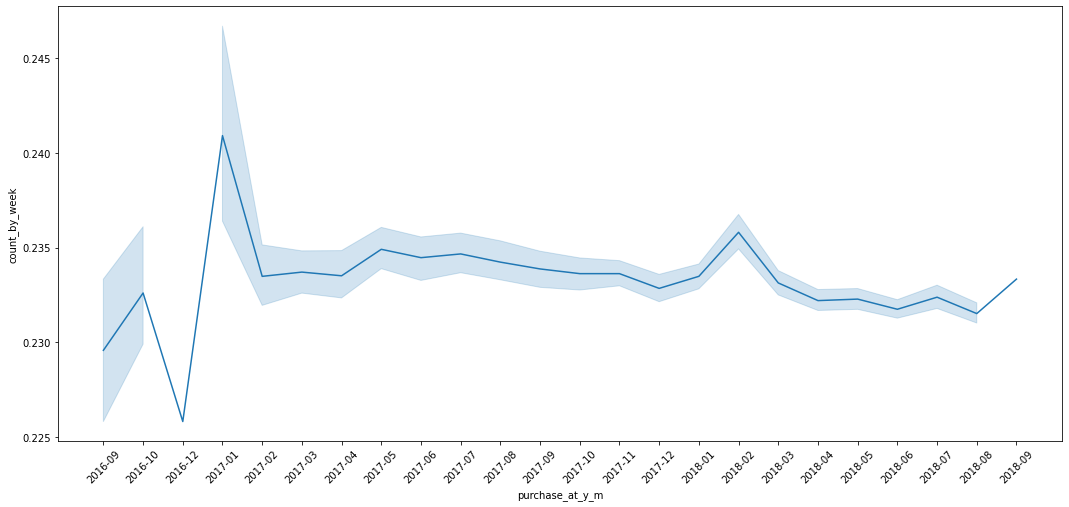

In [21]:
# отразим на графике движение количества покупок в неделю по месяцам
plt.figure(figsize=(18,8))
plt.xticks(rotation = 45)
sns.lineplot(data = order_count_by_week.sort_values('purchase_at_y_m', ascending = True),\
                                         x = 'purchase_at_y_m', y = 'count_by_week')

На графике видим, что наибольшее количество покупок в неделю пользователи делали в январе 2017 года.

## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Признак формирования когорты — повторная покупка на третий месяц\
Размер когорты — временной интервал: месяц\
Отчетный период — 2017 год\
Анализируемый ключевой показатель: Retention Rate

In [22]:
# определим даты первой покупки и последней в датасете
print(f'Дата первой покупки: {customers_orders_df.order_purchase_timestamp.min()}\n\
Дата последней покупки: {customers_orders_df.order_purchase_timestamp.max()}')

Дата первой покупки: 2016-09-04 21:15:19
Дата последней покупки: 2018-10-17 17:30:18


Для исследование возьмём 2017 год, как полный. При этом последним месяцем будем считать 2018-03, чтобы учесть когорты до декабря 2017 г.

In [23]:
# создадим датафрейм с нужными нам колонками айди клиента, датой заказа и датой подтверждения заказа
unique_users_per_month_df = customers_orders_df [['customer_unique_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at']]
# отфильтруем даты заказы в соответствии с условием по датам выше
unique_users_per_month_df = unique_users_per_month_df.query('order_purchase_timestamp>="2017-01-01" and order_purchase_timestamp<="2018-03-31"')
# а также отфильтруем на соответствие критерию покупки
unique_users_per_month_df = unique_users_per_month_df.query('order_approved_at != "NaT" and order_status in ("processing", "shipped", "delivered", "unavailable")')

In [24]:
# в отдельный столбец выделим год и месяц заказа
unique_users_per_month_df ['purchase_month'] = customers_orders_df.order_purchase_timestamp.dt.strftime('%Y-%m')

In [25]:
unique_users_per_month_df.head()

,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,purchase_month
0,861eff4711a542e4b93843c6dd7febb0,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01
3,259dac757896d24d7702b9acbbff3f3c,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03
5,4c93744516667ad3b8f1fb645a3116a4,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09
6,addec96d2e059c80c30fe6871d30d177,delivered,2018-02-19 14:38:35,2018-02-19 14:50:37,2018-02


In [26]:
# в отдельный датафрейм сохраним самый первый месяц заказа по пользователям
first_order_month = unique_users_per_month_df.groupby('customer_unique_id', as_index = False)\
                                        .agg({'purchase_month':'min'})\
                                        .rename (columns = {'purchase_month':'first_order_month'})

In [27]:
# объеденим датафрейм с первым заказом с нашим рабочим датафреймом
unique_users_per_month_df = unique_users_per_month_df.merge(first_order_month, on = 'customer_unique_id', how = 'inner')

In [28]:
unique_users_per_month_df.head()

,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,purchase_month,first_order_month
0,861eff4711a542e4b93843c6dd7febb0,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01,2018-01
2,259dac757896d24d7702b9acbbff3f3c,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03,2018-03
3,4c93744516667ad3b8f1fb645a3116a4,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09,2017-09
4,4c93744516667ad3b8f1fb645a3116a4,delivered,2017-10-15 12:44:13,2017-10-15 13:05:29,2017-10,2017-09


In [29]:
# посчитаем количество уникальных пользователей внутри первого месяца заказа и по возвращаемости на каждый последующий месяц
unique_users_per_month_df = unique_users_per_month_df.groupby (['first_order_month', 'purchase_month'], as_index = False)\
                    .agg({'customer_unique_id':'nunique'})\
                    .rename (columns = {'customer_unique_id':'count_of_unique_users'})

In [30]:
unique_users_per_month_df.head()

,first_order_month,purchase_month,count_of_unique_users
0,2017-01,2017-01,749
1,2017-01,2017-02,3
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


In [31]:
# создадим колонку, показывающую номер месяца для каждой когорты, считая от месяца первого заказа
unique_users_per_month_df ['month'] = unique_users_per_month_df.groupby('first_order_month').cumcount()

In [32]:
unique_users_per_month_df.head()

,first_order_month,purchase_month,count_of_unique_users,month
0,2017-01,2017-01,749,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4


In [33]:
# в отдельный датасет сохраним количество пользователей по первому месяцу
count_of_unique_users = unique_users_per_month_df.query('month == 0 and first_order_month<="2017-12"')\
                        [['first_order_month', 'count_of_unique_users']].set_index('first_order_month')   

In [34]:
count_of_unique_users.head()

,count_of_unique_users
first_order_month,
2017-01,749
2017-02,1711
2017-03,2600
2017-04,2320
2017-05,3555


In [35]:
# создадим датасет, в который запишем сводную таблицу по месяцовым когортам и количеству пользователей на каждый
# последующий месяц по колонкам
rr_df = unique_users_per_month_df.pivot (index = "first_order_month", columns = 'month', values = 'count_of_unique_users')\
                    .query('index<="2017-12"')\
                    .divide(count_of_unique_users.count_of_unique_users, axis=0)
# в качестве нулевого месяца запишем точное число пользователей в этом месяц
rr_df [0] = count_of_unique_users.count_of_unique_users

In [36]:
rr_df

month,0,1,2,3,4,5,6,7,8,9,10,11,12,13
first_order_month,,,,,,,,,,,,,,
2017-01,749,0.004005,0.002670,0.001335,0.004005,0.001335,0.005340,0.001335,0.001335,0.004005,0.001335,0.008011,0.004005,0.001335
2017-02,1711,0.002338,0.002922,0.001169,0.004091,0.001169,0.002338,0.001753,0.001169,0.002338,0.001169,0.002922,0.001753,0.001753
2017-03,2600,0.005000,0.003462,0.003846,0.003462,0.001538,0.001538,0.003077,0.003462,0.000769,0.003462,0.001538,0.002308,NaN
2017-04,2320,0.006034,0.002155,0.001724,0.003017,0.002586,0.003448,0.003017,0.003017,0.001724,0.002586,0.000862,NaN,NaN
2017-05,3555,0.004782,0.005063,0.003938,0.003094,0.003376,0.004219,0.001688,0.002532,0.002813,0.002532,NaN,NaN,NaN
2017-06,3118,0.004490,0.003528,0.004169,0.002566,0.003528,0.003528,0.002245,0.001283,0.002245,NaN,NaN,NaN,NaN
2017-07,3862,0.005179,0.003366,0.002589,0.002848,0.002071,0.003107,0.001036,0.001813,NaN,NaN,NaN,NaN,NaN
2017-08,4144,0.006757,0.003378,0.002654,0.003620,0.005309,0.002896,0.002413,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4098,0.006833,0.005368,0.002928,0.004636,0.002196,0.002196,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# для построения sns.heatmap возьмём в отдельный датасет столбцы по 1-3 месяцам
rr_df_for_map = rr_df [[1, 2, 3]]

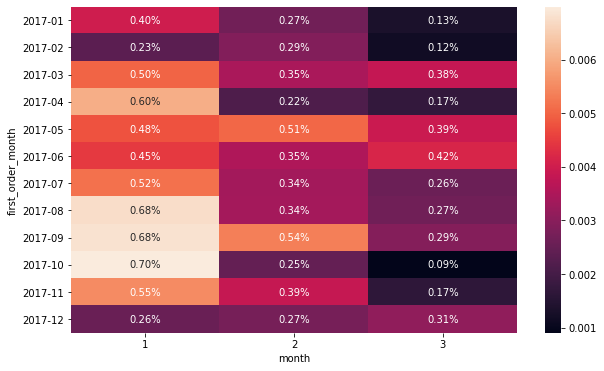

In [38]:
# строим sns.heatmap
plt.figure(figsize=(10,6))
sns.heatmap (rr_df_for_map, fmt='.2%', annot = True)

Из тепловой карты видно, что самые успешные по Retention Rate на третий месяц когорты - 2017-03 (0.38%), 2017-05 (0.39%), 2017-06 (0.42%).

## 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

### Подготовка данных

Все подходящие для работы данные содержаться в ранее созданном нами датасете - union_df. 
Применим фильтр на определение покупки, а затем выделим из него нужные столбцы даты заказов, айди пользователей, стоимости покупок в заказах:\
customer_unique_id — уникальный идентификатор пользователя\
order_id — уникальный идентификатор заказа (номер чека)\
order_purchase_timestamp — время создания заказа\
order_item_id — идентификатор товара внутри одного заказа\
product_id — ид товара (аналог штрихкода)\
price - цена за единицу товара

In [39]:
rfm_df = union_df.query('order_approved_at != "NaT" and order_status in ("processing", "shipped", "delivered", "unavailable")')\
                [['customer_unique_id','order_id', 'order_purchase_timestamp', 'order_item_id', 'product_id', 'price']]\
                .dropna() #а также избавимся от NaN
rfm_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_item_id,product_id,price
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,1.0,4244733e06e7ecb4970a6e2683c13e61,58.90
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,1.0,e5f2d52b802189ee658865ca93d83a8f,239.90
2,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,1.0,c777355d18b72b67abbeef9df44fd0fd,199.00
3,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,1.0,7634da152a4610f1595efa32f14722fc,12.99
4,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,1.0,ac6c3623068f30de03045865e4e10089,199.90


### Воспользуемся методологией построения RFM
To get the RFM score of a customer, we need to first calculate the R, F and M scores on a scale from 1 (worst) to 5 (best).

1. calculate Recency = number of days since last purchase
2. calculate Freqency = number of purchases during the studied period (usually one year)
3. calculate Monetary = total amount of purchases made during the studied period
4. find quintiles for each of these dimensions
5. give a grade to each dimension depending in which quintiles it stands
6. combine R, F and M scores to get the RFM score
7. map RF scores to segments

### 1) Посчитаем Recency (время от последней покупки пользователя до текущей даты)

In [40]:
# определим самую последнюю дату в датасете, для этого выделим все столбцы с датами и найдём максимальное значение среди них
# сохраним это значение в отдельный столбец
rfm_df['today_date'] = orders_df [['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']]\
        .max().max()
rfm_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_item_id,product_id,price,today_date
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,1.0,4244733e06e7ecb4970a6e2683c13e61,58.90,2018-11-12
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,1.0,e5f2d52b802189ee658865ca93d83a8f,239.90,2018-11-12
2,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,1.0,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-11-12
3,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,1.0,7634da152a4610f1595efa32f14722fc,12.99,2018-11-12
4,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,1.0,ac6c3623068f30de03045865e4e10089,199.90,2018-11-12


Будем считать нашей текущей датой, к которой мы привязываемся - 2018-11-12

In [41]:
# создадим датафрейм для высчитывания даты последнего заказа по пользователям
last_purchase_date_df = rfm_df.groupby ('customer_unique_id', as_index = False)\
                    .agg({'order_purchase_timestamp':'max'})\
                    .rename (columns = {'order_purchase_timestamp':'last_purchase_date'})
# объединим рабочий датафрейм с указанным выше
rfm_df = rfm_df.merge (last_purchase_date_df, on = 'customer_unique_id', how = 'inner')
# добавим колонку R, в которой посчитаем количество дней между датой последнего заказа и текущей датой
rfm_df ["recency"] = (rfm_df.today_date - rfm_df.last_purchase_date).dt.days

In [42]:
rfm_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_item_id,product_id,price,today_date,last_purchase_date,recency
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,1.0,4244733e06e7ecb4970a6e2683c13e61,58.90,2018-11-12,2017-09-13 08:59:02,424
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,1.0,e5f2d52b802189ee658865ca93d83a8f,239.90,2018-11-12,2017-09-18 16:12:04,419
2,eb28e67c4c0b83846050ddfb8a35d051,c105be01f21c9df6a2579f59b95cbcd9,2017-09-18 16:12:04,1.0,d2f5484cbffe4ca766301b21ab9246dd,12.88,2018-11-12,2017-09-18 16:12:04,419
3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,1.0,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-11-12,2018-01-14 14:33:31,301
4,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,1.0,7634da152a4610f1595efa32f14722fc,12.99,2018-11-12,2018-08-08 10:00:35,95


### 2) Посчитаем Frequency (суммарное количество покупок у пользователя за всё время)

In [43]:
# в отдельный датасет сгруппируем пользователей по количеству заказов
frequency_df = rfm_df.groupby('customer_unique_id', as_index = False)\
                    .agg({'order_id':'count'})\
                    .rename (columns = {'order_id':'frequency'})
# объеденим с основным датасетом, таким образом добавится столбец "F"
rfm_df = rfm_df.merge (frequency_df, on = 'customer_unique_id', how = 'inner')

In [44]:
rfm_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_item_id,product_id,price,today_date,last_purchase_date,recency,frequency
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,1.0,4244733e06e7ecb4970a6e2683c13e61,58.90,2018-11-12,2017-09-13 08:59:02,424,1
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,1.0,e5f2d52b802189ee658865ca93d83a8f,239.90,2018-11-12,2017-09-18 16:12:04,419,2
2,eb28e67c4c0b83846050ddfb8a35d051,c105be01f21c9df6a2579f59b95cbcd9,2017-09-18 16:12:04,1.0,d2f5484cbffe4ca766301b21ab9246dd,12.88,2018-11-12,2017-09-18 16:12:04,419,2
3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,1.0,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-11-12,2018-01-14 14:33:31,301,1
4,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,1.0,7634da152a4610f1595efa32f14722fc,12.99,2018-11-12,2018-08-08 10:00:35,95,1


### 3) Посчитаем Monetary (сумма покупок за всё время)

In [45]:
# для этого в отдельный датасет сгруппируем пользователей по сумме price
monetary_df = rfm_df.groupby('customer_unique_id', as_index = False)\
                    .agg({'price':'sum'})\
                    .rename (columns = {'price':'monetary'})
rfm_df = rfm_df.merge(monetary_df, on = 'customer_unique_id', how = 'inner')

In [46]:
rfm_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_item_id,product_id,price,today_date,last_purchase_date,recency,frequency,monetary
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,1.0,4244733e06e7ecb4970a6e2683c13e61,58.90,2018-11-12,2017-09-13 08:59:02,424,1,58.90
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,1.0,e5f2d52b802189ee658865ca93d83a8f,239.90,2018-11-12,2017-09-18 16:12:04,419,2,252.78
2,eb28e67c4c0b83846050ddfb8a35d051,c105be01f21c9df6a2579f59b95cbcd9,2017-09-18 16:12:04,1.0,d2f5484cbffe4ca766301b21ab9246dd,12.88,2018-11-12,2017-09-18 16:12:04,419,2,252.78
3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,1.0,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-11-12,2018-01-14 14:33:31,301,1,199.00
4,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,1.0,7634da152a4610f1595efa32f14722fc,12.99,2018-11-12,2018-08-08 10:00:35,95,1,12.99


### 4) Найдём границы для Recency

In [47]:
# для начала отбросим ненужные столбцы, оставив только наши метрики для каждого пользователя
rfm_df = rfm_df.groupby('customer_unique_id')\
                .agg({'recency':'max', 'frequency':'max', 'monetary':'max'})

In [48]:
rfm_df.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,185,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,188,1,18.90
0000f46a3911fa3c0805444483337064,611,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,395,1,25.99
0004aac84e0df4da2b147fca70cf8255,362,1,180.00


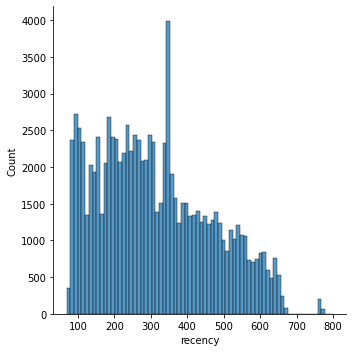

In [49]:
# посмотрим на распределение recency
sns.displot(rfm_df.recency)

На графике мы видим картинку, похожую на бетта-распределение. Так как пользователи распределены достаточно вариативно относительно метрики, в данном случае мы можем воспользовать квантилями для установления границ метрики. Установим границы Recency по значениям 0.25, 0.50, 0.75 квантилей. Чем меньше дней прошло с покупки, тем выше рейтинг и меньше значение R.

In [50]:
rfm_df.recency.describe()

count    94678.000000
mean       312.126133
std        152.830069
min         69.000000
25%        188.000000
50%        293.000000
75%        421.000000
max        798.000000
Name: recency, dtype: float64

In [51]:
# посчитаем квантили и напишем функцию для распределения метрики
q_25 = rfm_df.recency.quantile(0.25)
q_50 = rfm_df.recency.quantile(0.5)
q_75 = rfm_df.recency.quantile(0.75)

def r_score (df):
    if df <= q_25:
        return 1
    elif df <= q_50:
        return 2
    elif df <= q_75:
        return 3
    else:
        return 4

In [52]:
# создадим столбец для рейтинга Requency
rfm_df ['R'] = rfm_df.recency.apply (lambda x: r_score (x))

In [53]:
rfm_df.head()

,recency,frequency,monetary,R
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,185,1,129.90,1
0000b849f77a49e4a4ce2b2a4ca5be3f,188,1,18.90,1
0000f46a3911fa3c0805444483337064,611,1,69.00,4
0000f6ccb0745a6a4b88665a16c9f078,395,1,25.99,3
0004aac84e0df4da2b147fca70cf8255,362,1,180.00,3


### 5) Найдём границы для Frequency

<Figure size 1800x360 with 0 Axes>

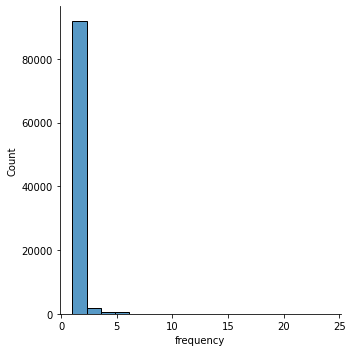

In [54]:
# посмотрим на распределение Frequency
plt.figure(figsize=(25,5))
sns.displot(rfm_df.frequency)

Наблюдаем очень большое отклонение значений в левую сторону.

In [55]:
# посмотрим на цифры
rfm_df.frequency.value_counts()

1     82916
2      8916
3      1666
4       626
5       243
6       195
7        46
8        16
11       11
10       11
9        10
12        9
14        3
13        2
15        2
20        2
21        1
16        1
18        1
24        1
Name: frequency, dtype: int64

Чаще всего пользователи совершали не больше одной покупки. Также есть большие кластеры по двум покупкам, трём покупкам, от 4 до 6 покупок, от 7 до 12 покупок, и остальные. Применим эти границы и поделим пользователей. Чем больше покупок, тем выше рейтинг и меньше значение F.

In [56]:
# напишем функцию для распределения метрики

def f_score (df):
    if df <= 1:
        return 6
    elif df <= 2:
        return 5
    elif df <= 3:
        return 4
    elif df <= 6:
        return 3
    elif df <= 12:
        return 2  
    else:
        return 1

In [57]:
rfm_df ['F'] = rfm_df.frequency.apply (lambda x: f_score (x))

In [58]:
rfm_df.head()

,recency,frequency,monetary,R,F
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,185,1,129.90,1,6
0000b849f77a49e4a4ce2b2a4ca5be3f,188,1,18.90,1,6
0000f46a3911fa3c0805444483337064,611,1,69.00,4,6
0000f6ccb0745a6a4b88665a16c9f078,395,1,25.99,3,6
0004aac84e0df4da2b147fca70cf8255,362,1,180.00,3,6


### 6) Найдём границы для Monetary

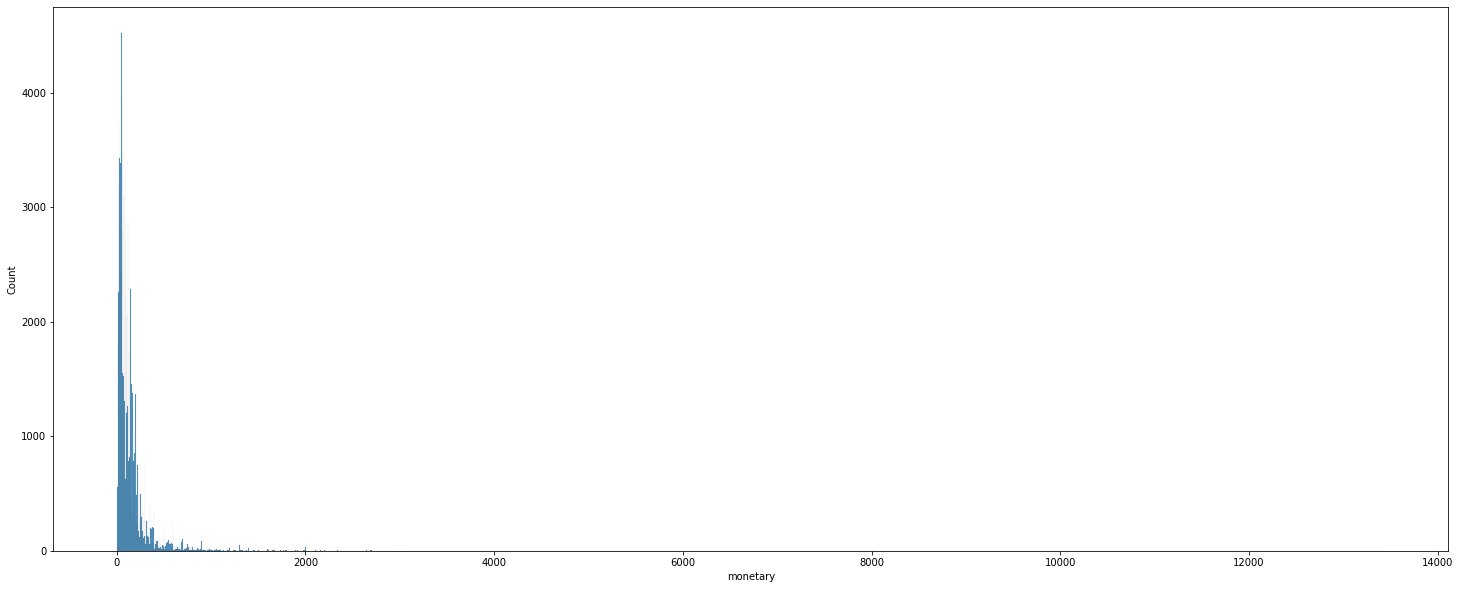

In [59]:
# посмотрим на распределение Monetary
plt.figure(figsize=(25,10))
sns.histplot(rfm_df.monetary)

Также, как у Frequency, наблюдает большой уклон значений влево.

In [60]:
# посмотрим на цифры
rfm_df.monetary.describe()

count    94678.000000
mean       141.880923
std        215.746300
min          0.850000
25%         47.800000
50%         89.800000
75%        154.910000
max      13440.000000
Name: monetary, dtype: float64

Максимальное значение Monetary - 13440, при этом большая часть пользователей (до 0.75 квантиля) не выходит за пределы отметки 154 (т.е. разброс по стоимости заказов между ними очень мал). Первой границей кластера мы возьмём 0.75 квантиль.

Теперь рассмотрим, что происходит за его пределами.

In [61]:
# распределение выше 0.75 квантиля
rfm_df.loc[rfm_df.monetary > rfm_df.monetary.quantile(0.75)].monetary.describe()

count    23668.000000
mean       355.026887
std        347.888227
min        154.960000
25%        189.000000
50%        242.600000
75%        370.000000
max      13440.000000
Name: monetary, dtype: float64

Будем считать верхней границей этого кластера 0.75 квантиль (370 долларов) данной выборки. Так мы захватим большую часть клиентов, при этом разброс Monetary не сильный. Посмотрим эту выборку выше 0.75 квантиля.

In [62]:
# распределение выше 0.75 квантиля от предыдущей выборки
rfm_df.loc[rfm_df.monetary > 370]\
        .monetary.describe()

count     5908.000000
mean       740.529980
std        526.011039
min        370.200000
25%        441.657500
50%        584.900000
75%        829.000000
max      13440.000000
Name: monetary, dtype: float64

Здесь нам подойдёт верхняя граница по 0.75 квантилю (829 долларов). Посмотрим эту выборку выше 0.75 квантиля.

In [63]:
# распределение выше 0.75 квантиля от предыдущей выборки
rfm_df.loc[rfm_df.monetary > 829]\
        .monetary.describe()

count     1474.000000
mean      1369.865475
std        730.668347
min        829.990000
25%        949.990000
50%       1177.900000
75%       1549.990000
max      13440.000000
Name: monetary, dtype: float64

Такое распределение подходит для кластера. Возьмём верхней границей 1550 долларов. И посмотрим выборку выше этого значения

In [64]:
rfm_df.loc[rfm_df.monetary > 1550]\
        .monetary.describe()

count      367.000000
mean      2234.798011
std       1018.027279
min       1554.000000
25%       1700.000000
50%       1989.000000
75%       2319.040000
max      13440.000000
Name: monetary, dtype: float64

Оставим выборку меньше 2320 как отдельный кластер. Пользователей, совершивших покупки на сумму более 2320, будем считать отдельным кластером по причине большой суммы и малочисленности.

Таким образом, наши кластеры:\
1 - больше 2320\
2 - больше 1550 и меньше 2320\
3 - больше 839 и меньше 1550\
4 - больше 370 и меньше 839\
5 - больше 155 и меньше 370\
6 - меньше 155


Создадим рейтинг. Чем выше сумма покупки, тем выше рейтинг и ниже значение M.

In [65]:
# напишем функцию для распределения метрики

def m_score (df):
    if df <= 155:
        return 6
    elif df <= 370:
        return 5
    elif df <= 839:
        return 4
    elif df <= 1550:
        return 3
    elif df <= 2320:
        return 2
    else:
        return 1

In [66]:
rfm_df ['M'] = rfm_df.monetary.apply (lambda x: m_score (x))

In [67]:
rfm_df.head()

,recency,frequency,monetary,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,185,1,129.90,1,6,6
0000b849f77a49e4a4ce2b2a4ca5be3f,188,1,18.90,1,6,6
0000f46a3911fa3c0805444483337064,611,1,69.00,4,6,6
0000f6ccb0745a6a4b88665a16c9f078,395,1,25.99,3,6,6
0004aac84e0df4da2b147fca70cf8255,362,1,180.00,3,6,5


### 7) Построим столбец RFM - рейтинга

In [68]:
rfm_df ['RFM'] = rfm_df.R.astype('str') + rfm_df.F.astype('str') + rfm_df.M.astype('str')

In [69]:
rfm_df.head()

,recency,frequency,monetary,R,F,M,RFM
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,185,1,129.90,1,6,6,166
0000b849f77a49e4a4ce2b2a4ca5be3f,188,1,18.90,1,6,6,166
0000f46a3911fa3c0805444483337064,611,1,69.00,4,6,6,466
0000f6ccb0745a6a4b88665a16c9f078,395,1,25.99,3,6,6,366
0004aac84e0df4da2b147fca70cf8255,362,1,180.00,3,6,5,365


Посмотрим, как распределёны кластеры RFM по количеству пользователей

In [70]:
# создадим датафрейм для построения графиков
rfm_plot_df = rfm_df.groupby('RFM', as_index = False)\
                    .agg({'recency':'count'})\
                    .rename(columns = {'recency':'count_of_customers'})\
                    .sort_values('count_of_customers', ascending = False)

In [71]:
rfm_plot_df.head()

,RFM,count_of_customers
30,166,16297
60,266,16295
120,466,16191
90,366,16082
119,465,3497


Text(0, 0.5, 'Количество клиентов')

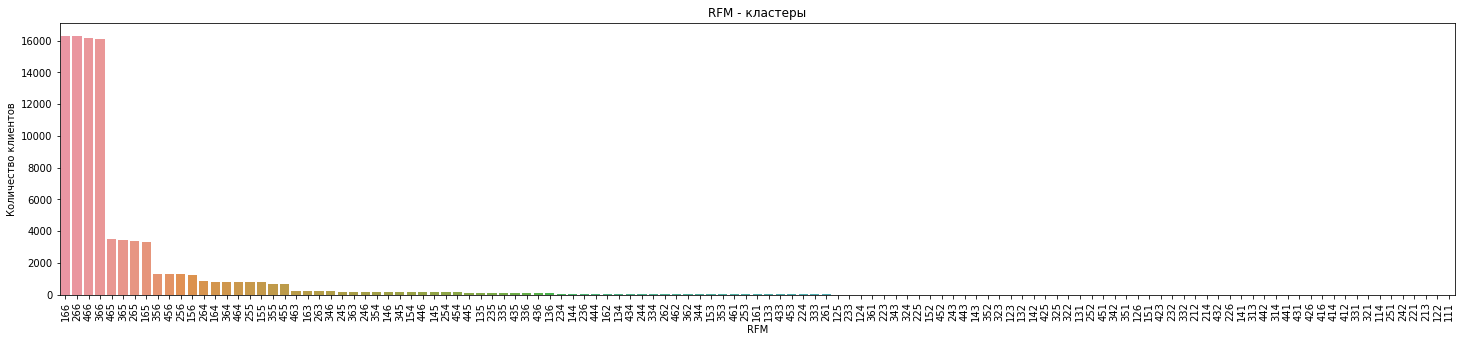

In [72]:
plt.figure(figsize=(25,5))
sns.barplot (data = rfm_plot_df, x = 'RFM', y = 'count_of_customers')

plt.xticks(rotation=90)
plt.title('RFM - кластеры')
plt.xlabel('RFM')
plt.ylabel('Количество клиентов')

Описание RFM:\
R (разница между текущей датой и датой последней покупки):\
1 - не более 188 дней\
2 - от 189 до 293 дней\
3 - от 294 до 421 дня\
4 - больше 421 дней

F (количество покупок):\
1 - больше 12 покупок\
2 - от 7 до 12 покупок\
3 - от 4 до 6 покупок\
4 - 3 покупки\
5 - 2 покупки\
6 - 1 покупка

M (суммарная стоимость покупок):\
1 - от 2320 до 13340\
2 - больше 1550 и меньше 2320\
3 - больше 839 и меньше 1550\
4 - больше 370 и меньше 839\
5 - больше 155 и меньше 370\
6 - меньше 155

По графику можем разбить кластеры на группы по количеству клиентов.\
1. Первая группа составляет абсолютное большинство - кластеры 166, 266, 466, 366 - это те, кто совершил по одной покупке на минимальную сумму, при этом давность покупки различается. Тоесть такие клиенты - это тренд для нашего магазина уже на протяжении года и больше.\
2. Вторая группа - кластеры 465, 365, 265, 165 - те, кто совершил по одной покупке на сумму от 155 до 370 долларов, при этом давность также различается. Таких клиентов меньше, но это тоже многочисленная часть аудитории.\
3. Третья группа - кластеры 456, 356, 156, 356, 264, 164, 364, 464, 255, 155, 355, 455 - те, кто совершил одну или две покупки, при этом стоимость может доходить до 839 долларов.\
4. Четвертая группа - все остальные.

Чтобы понять, какие кластеры приносят нам наибольший доход, построим график распределения Monetary по кластерам.

In [73]:
rfm_monetary_df = rfm_df.groupby ('RFM', as_index = False)\
                        .agg ({'monetary':'sum'})\
                        .sort_values ('monetary', ascending = False)
rfm_monetary_df

,RFM,monetary
60,266,1143977.94
30,166,1140922.94
90,366,1116644.30
120,466,1091942.38
119,465,791807.79
...,...,...
1,114,729.62
6,126,323.65
38,226,219.23
96,426,108.90


Text(0, 0.5, 'Monetary')

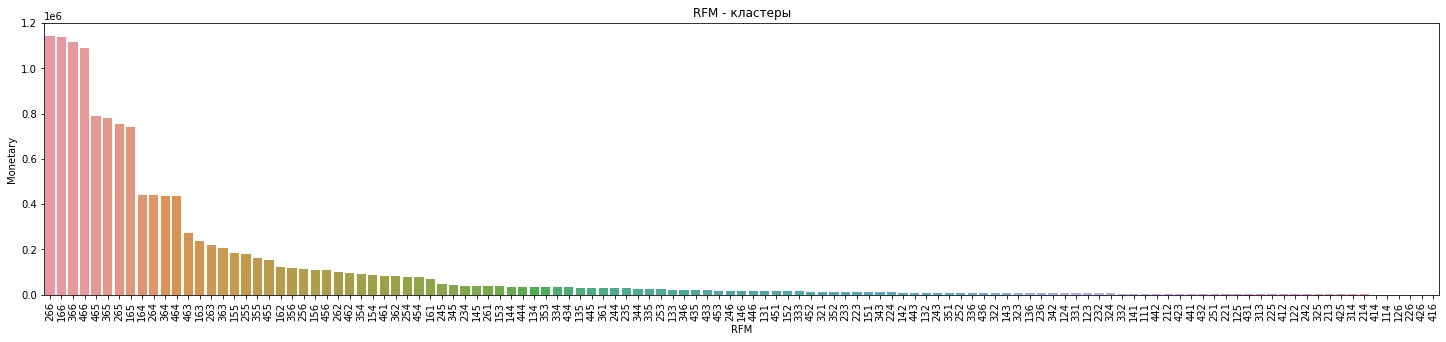

In [74]:
plt.figure(figsize=(25,5))
sns.barplot (data = rfm_monetary_df, x = 'RFM', y = 'monetary')
plt.xticks(rotation=90)
plt.title('RFM - кластеры')
plt.xlabel('RFM')
plt.ylabel('Monetary')

1. Первая группа - 266, 166, 366, 466 - по доходу более 1.1 миллиона долларов.\
2. Вторая группа - 465, 365, 265, 165 - по доходу около 0.8 миллиона долларов.\
3. Третья группа - 164, 264, 364, 464 - по доходу около 0.5 миллиона долларов.\
4. Четвёртая группа - остальные - по доходу менее 0.3 миллиона долларов.

Мы видим, что наши распределение групп по доходу и распределение по численности клиентов очень хорошо коррелируют, первое почти полностью входит во второе.

### 8) Построим матрицу сегментов
По анализу Monetary нам стала более понятна основная аудитория, приносящая доход. Теперь построим сегменты нашей аудитории основываясь на рейтингах R и F. Всего мною выделено 10 сегментов.

![Сегменты по R и F](RF.PNG)

In [89]:
# добавим сегменты в датафрейм
segt_map = {
    r'1[1-3]': 'лояльные',
    r'[2-4][1-3]': 'уснувшие лояльные',
    r'14': 'проявившие лояльность',
    r'24': 'риск потери лояльности',
    r'[3-4]4': 'потерявшие лояльность',
    r'15': 'дали второй шанс',
    r'[2-3]5': 'заснувшие',
    r'45': 'ушли от нас',
    r'16': 'недавние новые',
    r'26': 'шанс на вторую покупку',
    r'[3-4]6':'невернувшиеся'
}

rfm_df['segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str)
rfm_df['segment'] = rfm_df['segment'].replace(segt_map, regex=True)

In [90]:
rfm_df.head()

,recency,frequency,monetary,R,F,M,RFM,segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,185,1,129.90,1,6,6,166,недавние новые
0000b849f77a49e4a4ce2b2a4ca5be3f,188,1,18.90,1,6,6,166,недавние новые
0000f46a3911fa3c0805444483337064,611,1,69.00,4,6,6,466,невернувшиеся
0000f6ccb0745a6a4b88665a16c9f078,395,1,25.99,3,6,6,366,невернувшиеся
0004aac84e0df4da2b147fca70cf8255,362,1,180.00,3,6,5,365,невернувшиеся


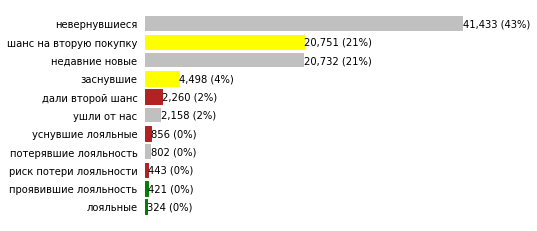

In [95]:
# построим график количества клиентов по каждому сегменту
segments_counts = rfm_df['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['лояльные', 'проявившие лояльность']:
            bar.set_color('green')
        if segments_counts.index[i] in ['уснувшие лояльные', 'риск потери лояльности', 'дали второй шанс']:
            bar.set_color('firebrick')
        if segments_counts.index[i] in ['заснувшие', 'шанс на вторую покупку']:
            bar.set_color('yellow')       
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

### Выводы
1. На данный момент наша основная аудитория, которая приносит наибольший доход - люди, которые совершают 1 покупку, покупая на сумму до 839 долларов, при этом такие клиенты - это практически абсолютное большинство.
2. Retention Rate нашего магазина очень низок. Для увеличения дохода можно попробовать увеличить Retention именно этой аудитории - кластеры *66, *65, *64 - повлияв на неё рекламой или акциями. Возможно также, что дело в качестве товара, и люди не хотят возвращатся за новой покупкой.
3. У нас есть клиенты - например, по кластерам 111, 131, 321 - совершившие от 3 до 12 покупок на стоимость выше 2,5 тысяч до 13,3 тысяч долларов, тоесть закупающиеся большими партиями,но они немногочисленны. Возможно, стоит рассмотреть стратегии по привлечению именно таких клиентов.
4. По разбиению на сегменты можно сказать следующее:\
1) лояльных и проявивших лояльность клиентов очень мало, почти 0% от общего количества, но они есть\
2) чтобы повысить Retention, в первую очередь нужно обращать внимание на красные и на жёлтые сегменты на графике сегментов, эти пользователи наиболее расположены к повторным покупкам в нашем магазине.